In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121

Using TensorFlow backend.


In [3]:
disease_types=['COVID', 'non-COVID']
data_dir = 'covid/'
train_dir = os.path.join(data_dir)

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1225).png,0,COVID
1,COVID/Covid (433).png,0,COVID
2,non-COVID/Non-Covid (335).png,1,non-COVID
3,non-COVID/Non-Covid (380).png,1,non-COVID
4,COVID/Covid (622).png,0,COVID


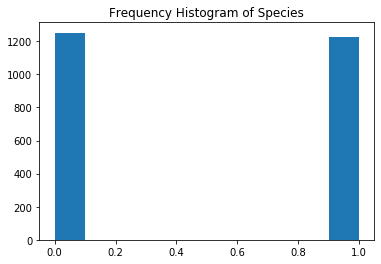

<Figure size 864x864 with 0 Axes>

In [6]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

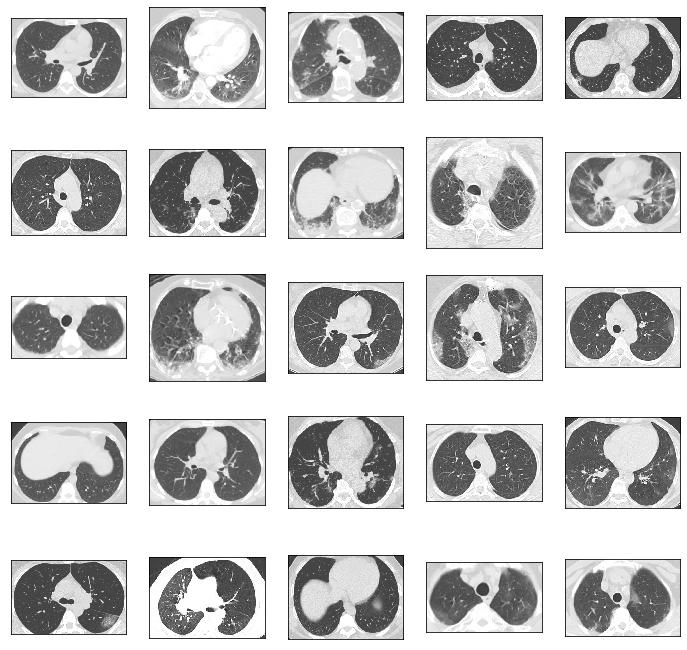

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

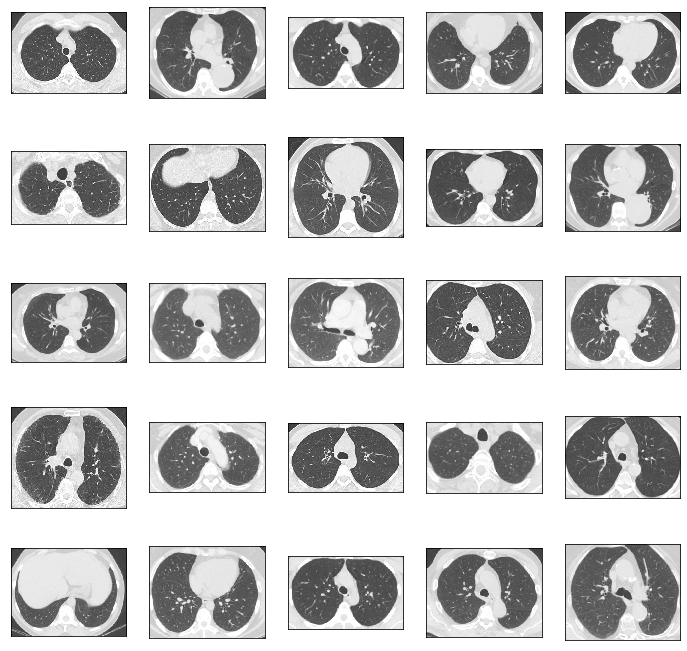

In [8]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [9]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [01:04, 38.40it/s]


Train Shape: (2481, 64, 64, 3)


In [11]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [12]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

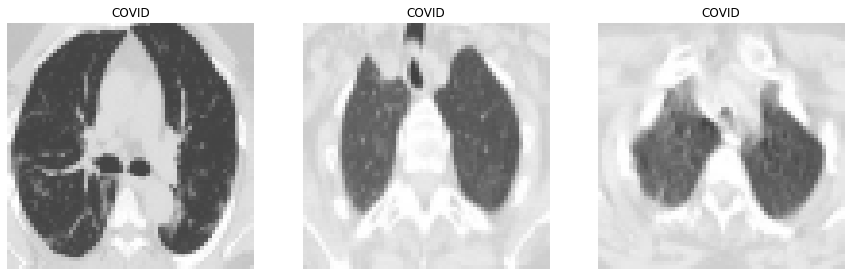

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [16]:
EPOCHS = 50
SIZE=64
N_ch=3

In [17]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [38]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

/home/vasanthan/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
31/31 - 98s - loss: 1.1545 - accuracy: 0.5267 - val_loss: 1.0713 - val_accuracy: 0.4547

Epoch 00001: val_loss improved from inf to 1.07128, saving model to model.h5
Epoch 2/5
31/31 - 71s - loss: 0.9416 - accuracy: 0.5922 - val_loss: 1.0272 - val_accuracy: 0.4386

Epoch 00002: val_loss improved from 1.07128 to 1.02725, saving model to model.h5
Epoch 3/5
31/31 - 68s - loss: 0.8115 - accuracy: 0.6487 - val_loss: 0.8324 - val_accuracy: 0.4970

Epoch 00003: val_loss improved from 1.02725 to 0.83238, saving model to model.h5
Epoch 4/5
31/31 - 70s - loss: 0.7260 - accuracy: 0.7132 - val_loss: 1.0034 - val_accuracy: 0.5111

Epoch 00004: val_loss did not improve from 0.83238
Epoch 5/5
31/31 - 69s - loss: 0.7052 - accuracy: 0.7132 - val_loss: 0.8476 - val_accuracy: 0.5594

Epoch 00005: val_loss did not improve from 0.83238


# LOAD MODEL

In [2]:
from tensorflow import keras
model = keras.models.load_model('covid-model.h5')

In [14]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 6s 189ms/step - loss: 0.2013 - accuracy: 0.9195
Final Loss: 0.20127634704113007, Final Accuracy: 0.9195170998573303


Text(0.5, 279.23999999999995, 'Predicted')

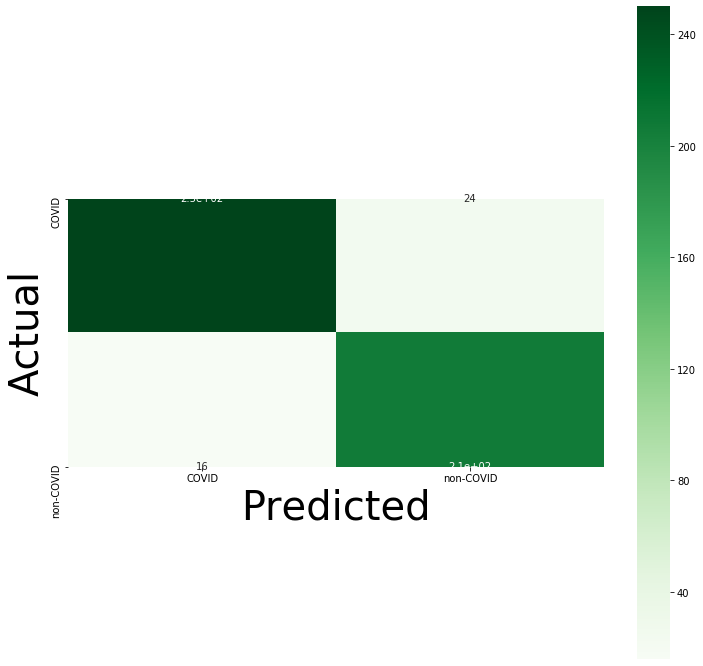

In [15]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

[9.994773e-01 5.226967e-04]


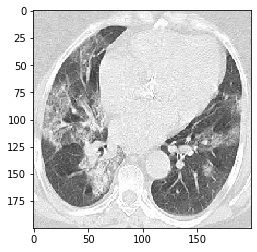

Prediction: Covid-19


In [45]:
from skimage import io
from keras.preprocessing import image

img = image.load_img('covid/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('covid/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))

disease_class=['Covid-19','Non Covid-19']

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [52]:
x.shape

(1, 64, 64, 3)

In [55]:
result = x[0, :, :, :]

In [56]:
result.shape

(64, 64, 3)

# LIME

In [18]:
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [75]:
explanation = explainer.explain_instance(result, model.predict, top_labels=5, hide_color=1, num_samples=1000)

100% |########################################################################|


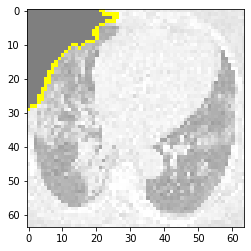

In [76]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

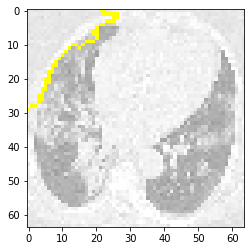

In [77]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

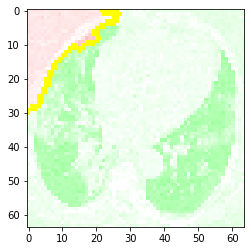

In [78]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

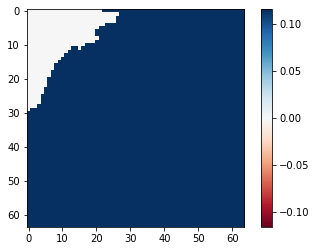

In [79]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Non-covid 

[0.11779483 0.8822051 ]


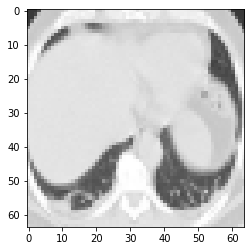

Prediction: Non Covid-19
Actual Class: [1. 0.]


In [80]:
x = image.img_to_array(X_val[0])
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)

print(custom[0])

plt.imshow(X_val[0])
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])
print('Actual Class:',Y_val[0])

In [81]:
explanation = explainer.explain_instance(X_val[0], model.predict, top_labels=5, hide_color=1, num_samples=1000)

100% |########################################################################|


In [82]:
from skimage.segmentation import mark_boundaries

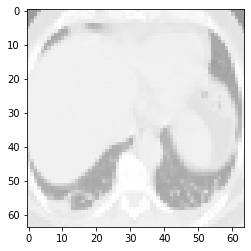

In [83]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

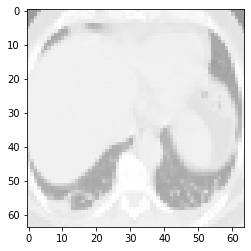

In [84]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

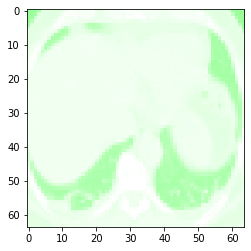

In [85]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

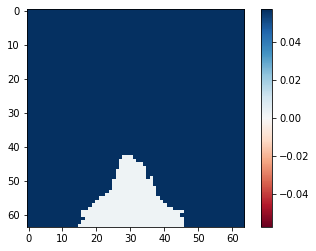

In [86]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [38]:
X_val.shape

(497, 64, 64, 3)

In [41]:
Y_val.shape

(497, 2)

[0.11468567 0.8853143 ]


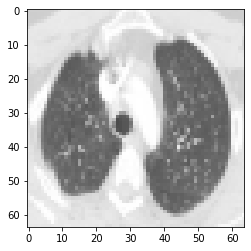

Prediction: Non Covid-19
Actual Class: [1. 0.]


In [87]:
idx = 52

x = image.img_to_array(X_val[idx])
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)

print(custom[0])

plt.imshow(X_val[idx])
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])
print('Actual Class:',Y_val[idx])

In [88]:
explanation = explainer.explain_instance(X_val[idx], model.predict, top_labels=5, hide_color=1, num_samples=1000)

100% |########################################################################|


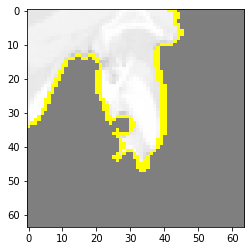

In [90]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

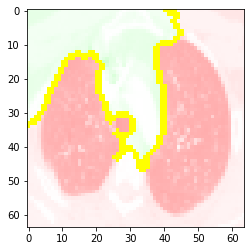

In [89]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

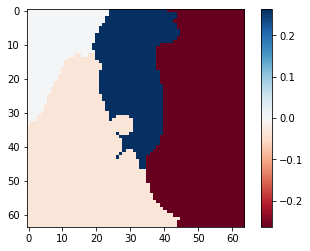

In [91]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# SHAP

In [70]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

In [71]:
shap_values = e.shap_values(X_val[1:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


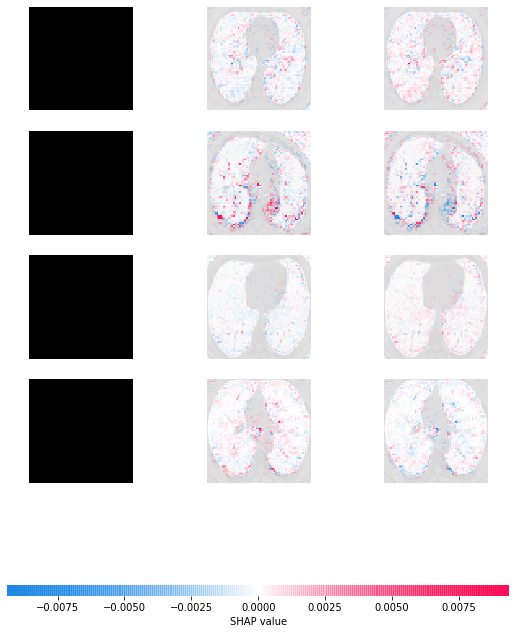

In [72]:
shap.image_plot(shap_values, -X_val[1:5])

In [95]:
e = shap.GradientExplainer(model, background)
shap_values,indexes = e.shap_values(X_val[1:5])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [100]:
print (indexes)

[[[[ 4.86388890e-05 -4.49903338e-04 -3.77690187e-04]
   [-1.04945106e-03 -1.40336726e-03 -3.82163067e-04]
   [-1.47381652e-04  9.82017227e-05  1.14010480e-04]
   ...
   [ 1.33631882e-04  2.27739656e-04  1.10313638e-04]
   [-1.17545447e-03 -9.25308850e-04 -2.05786011e-04]
   [-9.56459786e-04 -1.43651690e-04 -1.64902558e-05]]

  [[ 5.76433260e-04 -1.89031928e-03 -6.04564382e-04]
   [-5.01765229e-04 -1.20651315e-03 -4.34674148e-05]
   [-6.51998911e-04 -8.27559910e-04  2.16883433e-04]
   ...
   [ 4.85750090e-04 -9.49525100e-04 -2.88107869e-04]
   [-3.62535386e-04 -1.54258579e-03 -5.17531240e-04]
   [-1.13979005e-03 -6.77629199e-04 -1.27161373e-04]]

  [[ 4.54050198e-04 -1.00307493e-03 -2.98055646e-04]
   [ 2.72497011e-04 -1.27266336e-03 -1.96831083e-04]
   [-3.46276560e-04 -3.20223189e-04  4.98357229e-04]
   ...
   [ 2.77718937e-04 -7.09589920e-04 -1.73865265e-05]
   [ 5.37761836e-04 -1.29859662e-03 -6.76169817e-04]
   [ 3.24581488e-05 -2.39405228e-04  4.07941880e-05]]

  ...

  [[-1.39301

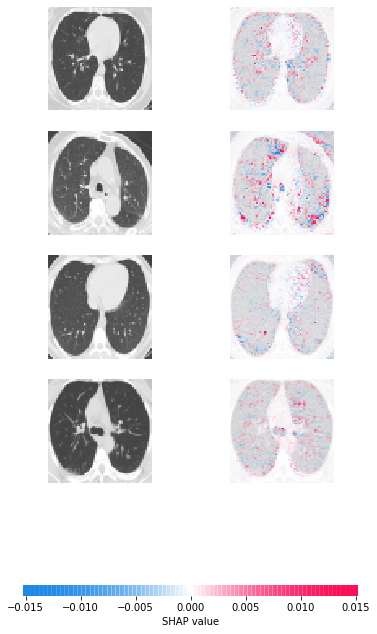

In [96]:
shap.image_plot(shap_values, X_val[1:5])